# <div align="center">Q-Agent on IGT      

# Game plan
1. add punishment (negative rewards) possibility rather then have choices have either 1 positive posibility or 0
 - new variable 'pvalues' in objects: MultiArmedBandit, Qagent



2. add a 2nd alpha for punishment (negative rewards)
 - changes need to be made in: MultiArmedBandit object, Qagent object
 - include conditional that checks for + or - negative "rewards" and changes alpha before computing (r is (+)rewards, p is (-)rewards):
 				Q(s,a) += alpha_r * (r + max,Q(s') - Q(s,a)) 
 				Q(s,a) += alpha_p * (p + max,Q(s') - Q(s,a)) 


3. use the actual decks of cards used for the IGT instead of randomized values for the decks
 - deck will come from a csv type file


4. explore the 3D of the parameter space - alpha, beta pairs and payoff
 - different alpha ratios
 - different alpha amplitudes
 - different beta amplitudes
 
 
5. create a 2D heat map for assymetry of learning and explore/exploit values
 - pick out agents that are greedy, moderate, etc, etc

 
 
---

## IGT game design 
100 Trials total (from Bechara, 1997)

Deck A
- p(r) = 0.5
- p(p) = 0.5
- reward: \$100
- punishment (avg): -\$250
- overall gains: -\$75

Deck B
- p(r) = 0.9
- p(p) = 0.1
- reward: \$100
- punishment (avg): -\$1250
- overall gains: -\$75

Deck C
- p(r) = 0.5
- p(p) = 0.5
- reward: \$50
- punishment (avg): -\$50
- overall gains: \$0

Deck D
- p(r) = 0.9
- p(p) = 0.1
- reward: \$50
- punishment (avg): -\$250
- overall gains: \$20

#### Alternative designs
- switch overall gains of C & D so that C has positive gains and keeps p(r)=0.5, 
	and D has $0 gains and keeps p(r)=0.9
	- may be interesting to see the effect of alpha on frequency of rewards

In [1]:
from __future__ import division
import numpy as np
from numpy import array
from numpy.random import sample as rs
from numpy import newaxis as na
import pandas as pd
from scipy.stats import sem
import seaborn as sns
import string
import matplotlib.pyplot as plt

#from ADMCode import visualize as vis 
#locally call, instead of pip install
%run visualize.py

In [2]:
def update_Qi(Qval, reward, alpha):
    """ update q-value of selected action, given reward and alpha
    """
    return Qval + alpha * (reward - Qval)


def update_Pall(Qvector, beta):
    """ update vector of action selection probabilities given
    associated q-values
    """
    return np.array([np.exp(beta*Q_i) / np.sum(np.exp(beta * Qvector)) for Q_i in Qvector])

In [ ]:
class IowaGamblingTask(object):
    """ defines a multi-armed bandit task

    ::Arguments::
        preward (list): 1xN vector of reward probabilities for each of N bandits
        rvalues (list): 1xN vector of payout values for each of N bandits
    """
    def __init__(self, feedback, nblocks=1):

        if nblocks>1:
            feedback = feedback.append([feedback]*(nblocks-1)).reset_index()

        feedback.rename(columns={'index':'t'}, inplace=True)
        self.feedback = feedback

        self.names = np.sort(self.feedback.columns.values)
        self.ntrials = self.feedback.shape[0]

        self.choices, self.all_traces = [], []
        self.rts = {k:[] for k in self.names}

        self.qdict = {k:[0] for k in self.names}
        self.choice_prob = {k:[1/self.names.size] for k in self.names}


    def get_feedback(self, trial, action_ix):

        choice_name = self.names[action_ix]
        return self.feedback.loc[trial, choice_name]

        #new_col = self.feedback[choice_name].shift(-1)
        #new_col.set_value(new_col.index[-1], oldval)
        #self.feedback.loc[:, choice_name] = new_col
        #return self.feedback.loc[:, choice_name] = new_col

In [3]:
class MultiArmedBandit(object):
    """ defines a multi-armed bandit task

    ::Arguments::
        preward (list): 1xN vector of reward probabilities for each of N decks
        rvalues (list): 1xN vector of payout values for each of N decks
        pvalues (list): 1xN vector of punishment values for each of N decks
    """

    def __init__(self, preward=[.5, .9, .5, .9], 
                       rvalues=[100, 100, 50, 50], 
                       pvalues=[-250, -1250, -50, -250]):

        self.preward = preward 
        self.rvalues = rvalues 
        self.pvalues = pvalues 
        
        try:
            assert(len(self.rvalues)==len(self.preward))
        except AssertionError:
            self.rvalues = np.ones(len(self.preward))
        
        try:
            assert(len(self.pvalues)==len(self.preward))
        except AssertionError:
            self.pvalues = np.ones(len(self.preward))


    def set_params(self, **kwargs):
        
        error_msg_r = """preward and rvalues must be same size
                    setting all rvalues to 1"""

        error_msg_p = """preward and pvalues must be same size
                    setting all pvalues to 1"""
        
        kw_keys = list(kwargs)
        
        # checking whether probability of rewards were passed as arguments
        if 'preward' in kw_keys:
            self.preward = kwargs['preward']
            
            # if not, will set them as 1, 100% of rewards
            if 'rvalues' not in kw_keys:
                try:
                    assert(len(self.rvalues)==len(self.preward))
                except AssertionError:
                    self.rvalues = np.ones(len(self.preward))

        # checking whether reward amounts were passed as arguments
        if 'rvalues' in kw_keys:
            self.rvalues = kwargs['rvalues']
            try:
                assert(len(self.rvalues)==len(self.preward))
            except AssertionError:
                raise(AssertionError, error_msg_r)

        # checking whether punishment amounts were passed as arguments
        if 'pvalues' in kw_keys:
            self.pvalues = kwargs['pvalues']
            try:
                assert(len(self.pvalues)==len(self.preward))
            except AssertionError:
                raise(AssertionError, error_msg_p)


    def get_feedback(self, action_ix):

        # probability of outcomes: p(reward), p(punishment)
        pOutcomes = np.array([self.preward[action_ix], 1-self.preward[action_ix]])
        
        # possible outcomes: reward amount (+), punishment amount(-)
        Outcomes = np.array([self.rvalues[action_ix], self.pvalues[action_ix]])

        # feedback: random selection with given amounts and probabilities
        feedback = np.random.choice(Outcomes, p=pOutcomes)
        return feedback

In [4]:
class Qagent(object):

    """ defines the learning parameters of single q-learning agent
    in a multi-armed bandit task

    ::Arguments::
        alpha_r (float): learning rate for rewards
        alpha_p (float): learning rate for punishments
        beta (float): inverse temperature parameter
        preward (list): 1xN vector of reward probaiblities for each of N decks
        rvalues (list): 1xN vector of payout values for each of N decks
                        IF rvalues is None, all values set to 1
        pvalues (list): 1xN vector of punishment values for each of N decks
                        IF rvalues is None, all values set to 1

    """

    def __init__(self, alpha_r=.04,
                       alpha_p=.02, 
                       beta=3.5, 
                       epsilon=.1, 
                       preward=[.2, .8, .2, .8], 
                       rvalues=[100, 100, 50, 50], 
                       pvalues=[-250, -1250, -50, -250]):


        #if rvalues is None:
            #rvalues = np.ones(len(preward))
        
        if pvalues is None:
            pvalues = np.zeros(len(preward))


        # calling MultiArmedBandit() function with arguments in Qagent() object
        #self.bandits = MultiArmedBandit(preward=preward, rvalues=rvalues, pvalues=pvalues)
        
        #initializing alpha(r) function to set which alpha to use depending on +-r
        self.alpha = lambda r: alpha_r if r > 0 else alpha_p
        
        # initializing updateQ() function to pass arguments through later
        self.updateQ = lambda Qval, r: Qval + self.alpha*(r - Qval)

        # initializing updateP() function to pass arguments through later
        self.updateP = lambda Qvector, act_i, beta: np.exp(beta*Qvector[act_i])/np.sum(np.exp(beta*Qvector))
        
        # setting parameters passed through Qagent() as arguments
        self.set_params(alpha_r=alpha_r, alpha_p=alpha_p, beta=beta, epsilon=epsilon)


    def set_params(self, **kwargs):
        
        """ update parameters of q-learning agent:
                alpha_r = learning rate for rewards
                alpha_p = learning rate for punishments
                beta = inv. temperature,
                epsilon = exploration constant to randomize decisions
                preward = probability of reward, p(reward)
                rvalues = reward amounts  (+$)
                pvalues = punishment amounts (-$)
        """

        kw_keys = list(kwargs)

        if 'alpha_r' in kw_keys:
            self.alpha_r = kwargs['alpha_r']

        if 'alpha_p' in kw_keys:
            self.alpha_p = kwargs['alpha_p']

        if 'beta' in kw_keys:
            self.beta = kwargs['beta']

        if 'epsilon' in kw_keys:
            self.epsilon = kwargs['epsilon']

        #if 'preward' in kw_keys:
            #self.bandits.set_params(preward=kwargs['preward'])

        #if 'rvalues' in kw_keys:
            #self.bandits.set_params(rvalues=kwargs['rvalues'])

        #if 'pvalues' in kw_keys:
            #self.bandits.set_params(pvalues=kwargs['pvalues'])

        # number of choices/options
        self.nact = len(self.bandits.preward)

        # actions limited to number of choices/options
        self.actions = np.arange(self.nact)


    def play_bandits(self, ntrials=100, get_output=True):
        
        """ simulates agent performance on a multi-armed bandit task

        ::Arguments::
            ntrials (int): number of trials to play bandits
            get_output (bool): returns output DF if True (default)

        ::Returns::
            DataFrame (Ntrials x Nbandits) with trialwise Q and P
            values for each bandit
        """

        pdata = np.zeros((ntrials + 1, self.nact))
        pdata[0, :] = np.array([1/self.nact]*self.nact)
        qdata = np.zeros_like(pdata)
        self.choices = []
        self.feedback = []

        for t in range(ntrials):

            # select bandit arm (action)
            act_i = np.random.choice(self.actions, p=pdata[t, :])

            # observe feedback
            r = self.bandits.get_feedback(act_i)

            # update value of selected action depending on whether it is a reward or punishment
            qdata[t+1, act_i] = update_Qi(qdata[t, act_i], r, self.alpha(r))

            # broadcast old q-values for unchosen actions
            for act_j in self.actions[np.where(self.actions!=act_i)]:
                qdata[t+1, act_j] = qdata[t, act_j]

            # update action selection probabilities and store data
            pdata[t+1, :] = update_Pall(qdata[t+1, :], self.beta)
            self.choices.append(act_i)
            self.feedback.append(r)

        self.pdata = pdata[1:, :]
        self.qdata = qdata[1:, :]
        self.make_output_df()

        if get_output:
            return self.data.copy()


    def make_output_df(self):
        """ generate output dataframe with trialwise Q and P measures for each bandit,
        as well as choice selection, and feedback
        """
        df = pd.concat([pd.DataFrame(dat) for dat in [self.qdata, self.pdata]], axis=1)
        columns = np.hstack(([['{}{}'.format(x, c) for c in self.actions] for x in ['q', 'p']]))
        df.columns = columns
        df.insert(0, 'trial', np.arange(1, df.shape[0]+1))
        df['choice'] = self.choices
        df['feedback'] = self.feedback
        r = np.array(self.bandits.rvalues)
        p = np.array(self.bandits.preward)
        df['optimal'] = np.where(df['choice']==np.argmax(p * r), 1, 0)
        df.insert(0, 'agent', 1)
        self.data = df.copy()


    def simulate_multiple(self, nsims=10, ntrials=1000):
        """ simulates multiple identical agents on multi-armed bandit task
        """
        dflist = []
        for i in range(nsims):
            data_i = self.play_bandits(ntrials=ntrials, get_output=True)
            data_i['agent'] += i
            dflist.append(data_i)
        return pd.concat(dflist)

In [5]:
# datax.head()

#  trial: trial number
#  q0: Q-value (i.e., expected value) of first bandit
#  p0: soft-max probability of selecting first bandit
#  choice: chosen bandit
#  feedback: feedback value returned by chosen bandit
#  optimal: did the agent choose the optimal action (1) or not (0)

Optimal Choice: 0.00


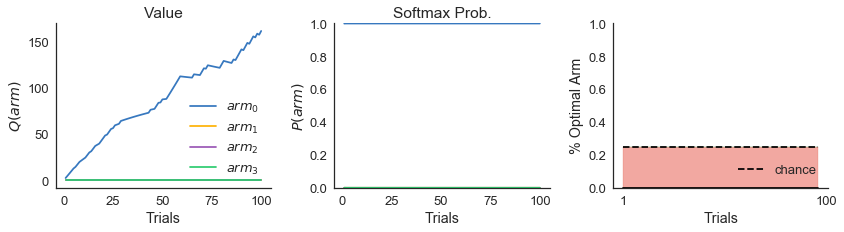

In [6]:
agent = Qagent(alpha_r=.02,
        alpha_p=-.01, 
        beta=3.5, 
        epsilon=.1, 
        preward=[.5, .9, .5, .9], 
        rvalues=[100, 100, 50, 50], 
        pvalues=[-250, -1250, -50, -250])

# play 800 trials of multi-armed bandit task
data0 = agent.play_bandits(ntrials=100, get_output=True)

data0.head()

# plot Q-values and softmax selection prob. for each bandit
plot_qlearning(data0)

Optimal Choice: 30.00


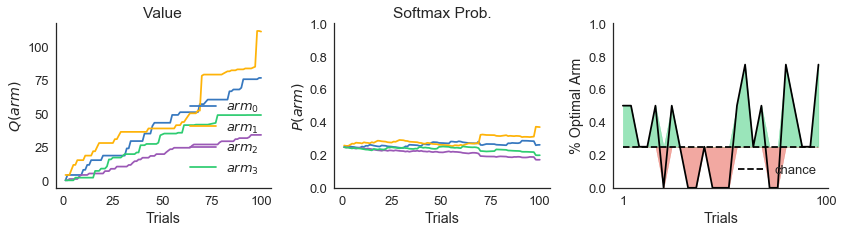

In [7]:
agent = Qagent(alpha_r=.04,
        alpha_p=-.02, 
        beta=.01, 
        epsilon=.1, 
        preward=[.5, .9, .5, .9], 
        rvalues=[100, 100, 50, 50], 
        pvalues=[-250, -1250, -50, -250])

# play 800 trials of multi-armed bandit task
data1 = agent.play_bandits(ntrials=100, get_output=True)

data1.head()

# plot Q-values and softmax selection prob. for each bandit
plot_qlearning(data1)

Optimal Choice: 35.00


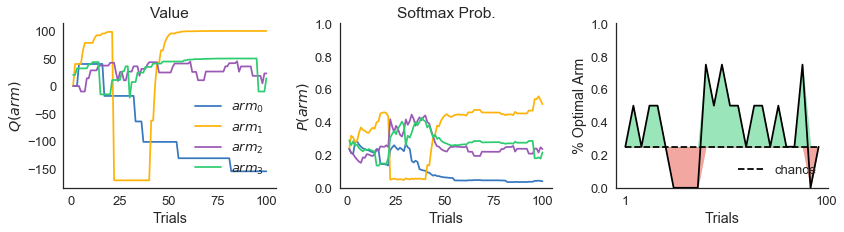

In [12]:
agent = Qagent(alpha_r=.4,
        alpha_p=.2, 
        beta=.01, 
        epsilon=.1, 
        preward=[.5, .9, .5, .9], 
        rvalues=[100, 100, 50, 50], 
        pvalues=[-250, -1250, -50, -250])

# play 800 trials of multi-armed bandit task
data2 = agent.play_bandits(ntrials=100, get_output=True)

data2.head()

# plot Q-values and softmax selection prob. for each bandit
plot_qlearning(data2)

Optimal Choice: 3.00


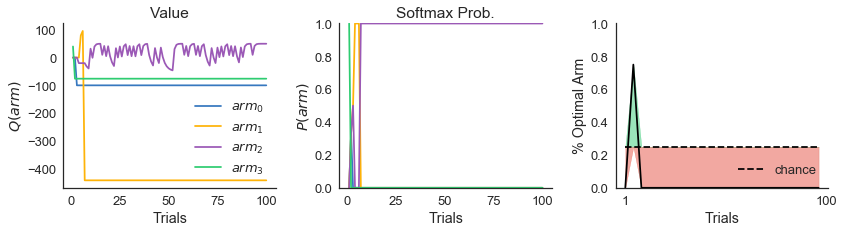

In [9]:
agent = Qagent(alpha_r=.8,
        alpha_p=.4, 
        beta=3.5, 
        epsilon=.1, 
        preward=[.5, .9, .5, .9], 
        rvalues=[100, 100, 50, 50], 
        pvalues=[-250, -1250, -50, -250])

# play 800 trials of multi-armed bandit task
data3 = agent.play_bandits(ntrials=100, get_output=True)

#  trial: trial number
#  q0: Q-value (i.e., expected value) of first bandit
#  p0: soft-max probability of selecting first bandit
#  choice: chosen bandit
#  feedback: feedback value returned by chosen bandit
#  optimal: did the agent choose the optimal action (1) or not (0)
data3.head()

# plot Q-values and softmax selection prob. for each bandit
plot_qlearning(data3)

Optimal Choice: 2.00


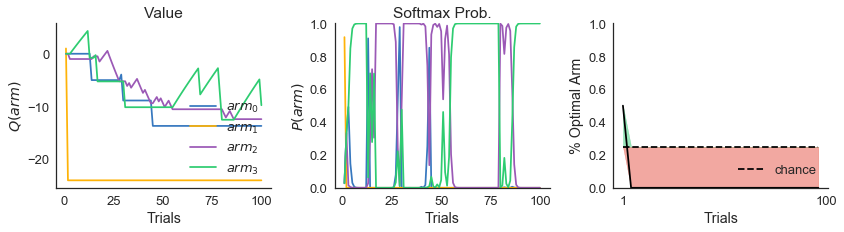

In [10]:
agent = Qagent(alpha_r=.01,
        alpha_p=.02, 
        beta=3.5, 
        epsilon=.1, 
        preward=[.5, .9, .5, .9], 
        rvalues=[100, 100, 50, 50], 
        pvalues=[-250, -1250, -50, -250])

# play 800 trials of multi-armed bandit task
data4 = agent.play_bandits(ntrials=100, get_output=True)

#  trial: trial number
#  q0: Q-value (i.e., expected value) of first bandit
#  p0: soft-max probability of selecting first bandit
#  choice: chosen bandit
#  feedback: feedback value returned by chosen bandit
#  optimal: did the agent choose the optimal action (1) or not (0)
data4.head()

# plot Q-values and softmax selection prob. for each bandit
plot_qlearning(data4)

Optimal Choice: 0.00


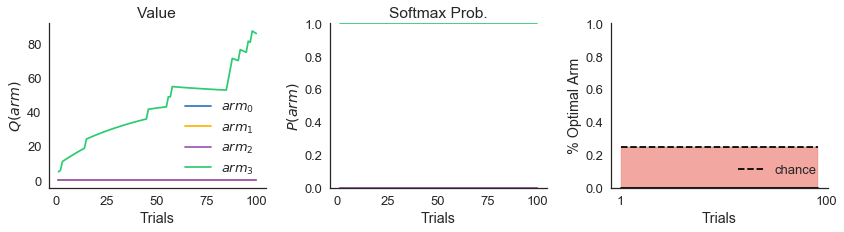

In [11]:
agent = Qagent(alpha_r=.02,
        alpha_p=-.02, 
        beta=3.5, 
        epsilon=.1, 
        preward=[.5, .9, .5, .9], 
        rvalues=[100, 100, 50, 50], 
        pvalues=[-250, -1250, -50, -250])

# play 100 trials of multi-armed bandit task
data5 = agent.play_bandits(ntrials=100, get_output=True)

data5.head()

# plot Q-values and softmax selection prob. for each bandit
plot_qlearning(data5)

magnitude of learning
greediness of decision policy
assymetry of decision policy

(looka t this whole space)

3d map --> sample, alpha, ratio, amplitudes, amplitudes of beta, giant map of payoff scores, sensitivty for configurations

find baseline parameters, lowest beta, lowest alpha, symmetrical learning rates

new repo, and porting this moves over the code, runs this notebook first, 

pulling from actual decks

2D heat map for assymetry of learning and ... greedy, moderate agents etc, and how they very along those dimensions
